# This alternative implements from_logits=True for loss function during compilation of the model, then outputs a softmax manually

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

RANDOM_STATE = 1234
np.random.seed(2)

tf.__version__

'2.13.0'

In [2]:
train = pd.read_csv("D:/githubrepo/ML_models/Work/digits/Data/train.csv")
test = pd.read_csv("D:/githubrepo/ML_models/Work/digits/Data/test.csv")

In [3]:
X_train = train.drop(['label'], axis=1)
y_train = train['label']

del train

In [4]:
X_train = X_train / 255.0
test = test / 255.0

In [5]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [6]:
y_train = pd.get_dummies(data=y_train).astype(int)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE)

#### Architecture based on LeNet-5, with Conv->MaxPool->Dropout->Conv->MaxPool->Dropout->Flatten->Dense->Dense

#### Padding is set as Same (=1). First Conv's stride is 1,1, while the second is 2,2

In [8]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='Same', 
                       activation=tf.nn.relu, input_shape = (28,28,1)))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))


model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', 
                       activation=tf.nn.relu, input_shape = (28,28,1)))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation=tf.nn.relu))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='linear'))

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

## Data Augmentation

In [10]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range=12,
  zoom_range=0.1,
  width_shift_range=0.1,
  height_shift_range=0.1
)
# Horizontal and Vertical flips should always be false for image recognition, as it would change the number to something else.
# Be careful using rotation_range, as it might cause numbers to be seen differently, which would negatively affect the model. 

datagen.fit(X_train)

In [11]:
data_iterator = datagen.flow(X_train, y_train)

In [12]:
epochs = 20
batch_size = 30

In [13]:
history = model.fit(data_iterator, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val)) #validation_data=(X_val, y_val)

Epoch 1/20
1182/1182 [==============================] - 56s 46ms/step - loss: 0.3397 - categorical_accuracy: 0.8913 - val_loss: 0.0646 - val_categorical_accuracy: 0.9793
Epoch 2/20
1182/1182 [==============================] - 48s 40ms/step - loss: 0.1284 - categorical_accuracy: 0.9607 - val_loss: 0.0479 - val_categorical_accuracy: 0.9843
Epoch 3/20
1182/1182 [==============================] - 49s 42ms/step - loss: 0.1021 - categorical_accuracy: 0.9684 - val_loss: 0.0398 - val_categorical_accuracy: 0.9867
Epoch 4/20
1182/1182 [==============================] - 51s 43ms/step - loss: 0.0912 - categorical_accuracy: 0.9729 - val_loss: 0.0306 - val_categorical_accuracy: 0.9907
Epoch 5/20
1182/1182 [==============================] - 55s 46ms/step - loss: 0.0769 - categorical_accuracy: 0.9767 - val_loss: 0.0296 - val_categorical_accuracy: 0.9905
Epoch 6/20
1182/1182 [==============================] - 60s 50ms/step - loss: 0.0719 - categorical_accuracy: 0.9783 - val_loss: 0.0364 - val_categoric

In [14]:
yhat = model.predict(X_train)
yhat = tf.nn.softmax(yhat)

1182/1182 [==============================] - 9s 8ms/step


In [15]:
yhat = yhat.numpy()

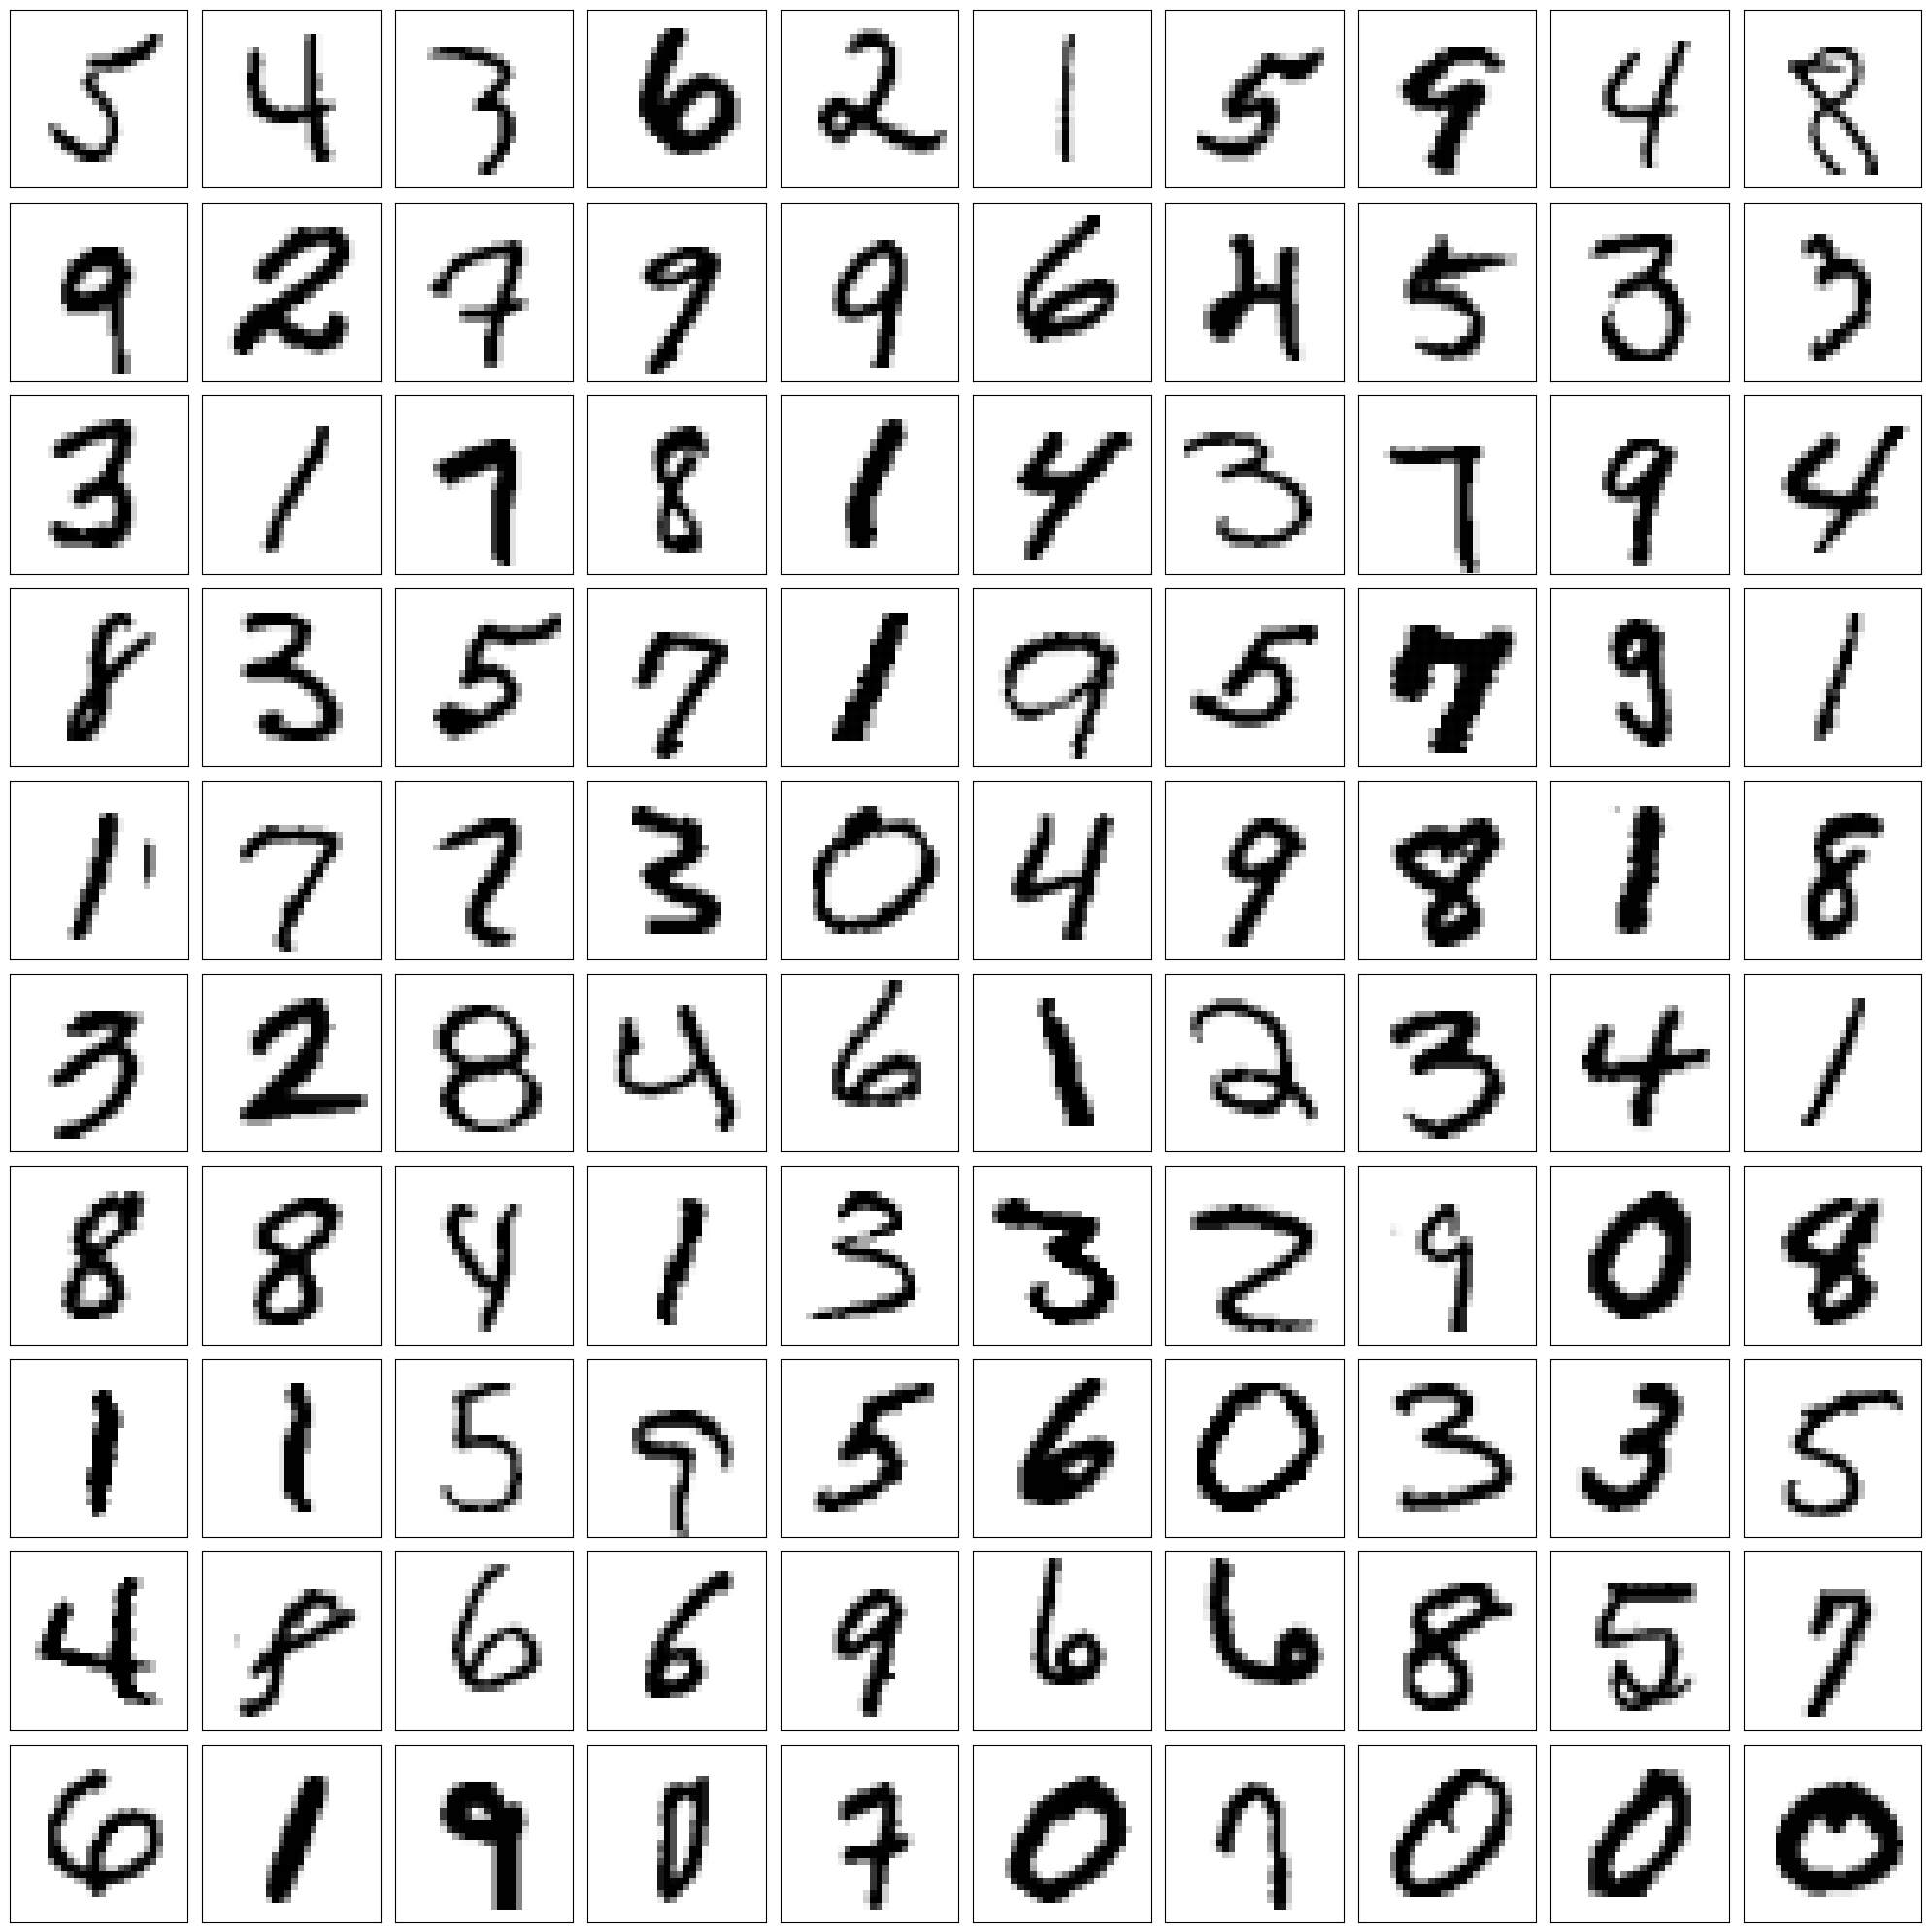

In [16]:
plt.figure(figsize=(20, 20))
for i in range(100):
  plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i], cmap=plt.cm.binary)
  if (y_train.iloc[i].argmax() != yhat[i].argmax()):
    plt.xlabel(f"Prediction: {yhat[i].argmax()}\n Actual: {y_train.iloc[i].argmax()}", color='red')
plt.tight_layout()
plt.show()

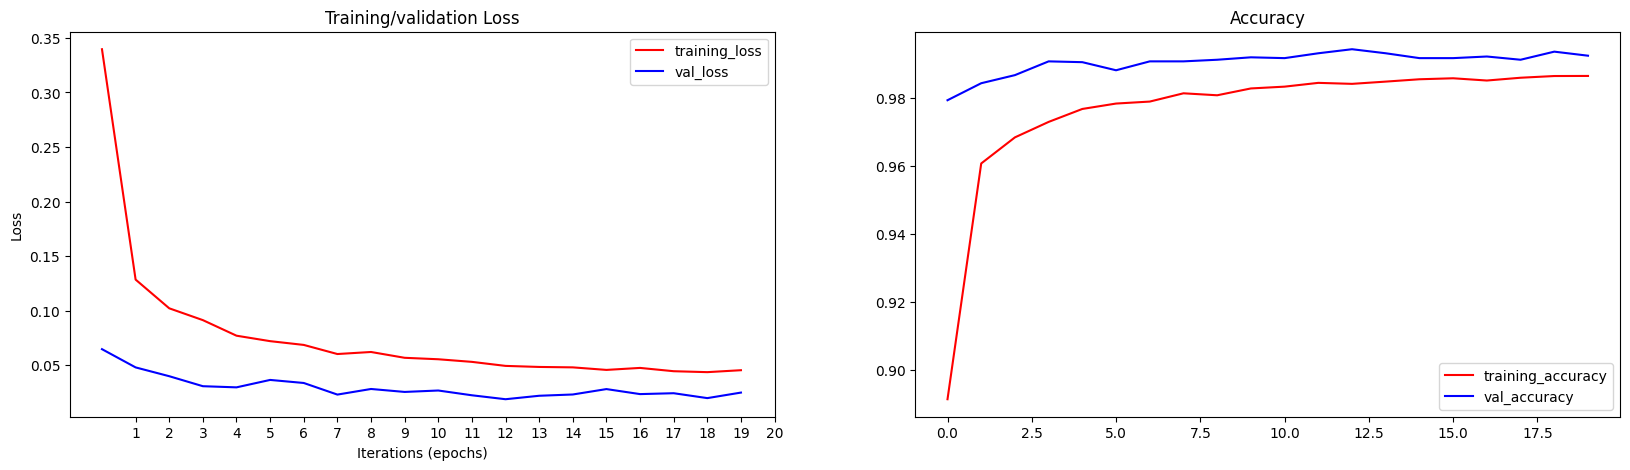

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title("Training/validation Loss")
ax[0].plot(history.history['loss'], label='training_loss', color='red')
ax[0].plot(history.history['val_loss'], label='val_loss', color='blue')
ax[0].set_xlabel("Iterations (epochs)")
ax[0].set_ylabel("Loss")
ax[0].set_xticks(range(1, epochs+1))
ax[0].legend()

ax[1].set_title("Accuracy")
ax[1].plot(history.history['categorical_accuracy'], label='training_accuracy', color='red')
ax[1].plot(history.history['val_categorical_accuracy'], label='val_accuracy', color='blue')
ax[1].legend()

In [29]:
print("Training Accuracy\n\t {}\n Validation Accuracy\n\t {}".format(model.evaluate(X_train, y_train)[1], model.evaluate(X_val, y_val)[1]))

132/132 [==============================] - 1s 7ms/step - loss: 0.0248 - categorical_accuracy: 0.9924
Training Accuracy
	 0.9962169528007507
 Validation Accuracy
	 0.9923809766769409


In [25]:
y_results = model.predict(test)
y_results = np.argmax(y_results, axis=1)

875/875 [==============================] - 6s 7ms/step


In [27]:
submission = pd.concat([pd.Series(range(1, 28001), name='ImageId'), pd.Series(y_results, name='Label')], axis=1)
submission.to_csv('cnn_digits.csv', index=False)

## Save model for upcoming execution

# Only run this section

In [23]:
model.save("nn.keras")
saved_model = keras.models.load_model("nn.keras")
saved_model.evaluate(X_train, y_train) 
#Check to see if traning accuracy for saved model is the same as the unsaved version

1182/1182 [==============================] - 8s 6ms/step - loss: 0.0119 - categorical_accuracy: 0.9962


[0.011882542632520199, 0.9962169528007507]